In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'
import torch
import numpy as np
from torch import nn, optim
import random
import torch.utils.tensorboard as tb

# Overview

## Game Environment

The game environment `GameEnv` is formally given by 

**State space:** $14$ since there are $14$ holes on the board

**Action space:** $6$ since there are $6$ holes a player can choose to redistribute

**Reward function:** TODO


The limit of the trajectories is 200 moves.

In [2]:
class GameEnv:
    def __init__(self, limit):
        self.state = None
        self.count = 0
        self.limit = limit
        self.state_dim = 14
        self.action_dim = 6
        self.rng = np.random.default_rng()
     

    def reset(self, state=np.array([4,4,4,4,4,4,0,4,4,4,4,4,4,0])):
        self.state = state
        self.count = 0
        
        return self.state
    
    def step(self, a):
        '''Parameters:
            a (int) : the action the learner will take'''

        self.count += 1

        # Keep track of the state before the learner moves
        sstate = self.state.copy()

        # Intermediate state, the state the learner will modify
        istate = sstate.copy()

        # Pieces the learner will move
        pieces = istate[a]

        # Set the state index to 0
        istate[a] = 0

        # First index to place pieces in 
        index = (a + 1) % 13
        
        # Distribute pieces
        while pieces > 0:
            istate[index] += 1
            index = (index + 1) % 13
            pieces -= 1
        
        # end state
        estate = istate.copy()

        # Random opponent
        # Pick random action
        rand_a = self.rng.integers(7, 13)
        rand_pieces = estate[rand_a]
        estate[rand_a] = 0

        rand_index = (rand_a + 1) % 14

        while rand_pieces > 0:
            if rand_index != 6:
                estate[rand_index] += 1
                rand_pieces = rand_pieces - 1

            rand_index = (rand_index + 1) % 14
                

        terminated = (estate[6] > 24) or (estate[13] > 24)
        truncated = self.count > self.limit

        # Reward every time learner is ahead
        if estate[6] > estate[13]:
            reward = 1
        else:
            reward = 0
        
        self.state = estate

        return sstate, istate, self.state, reward, terminated, truncated, a, rand_a

In [3]:
  
class DQN(nn.Module):
    
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, num_actions)
        )

    def forward(self, x):
        return self.model(x)

    def act(self, x):
        return self(x).argmax()
    

In [4]:
# Greg's code
class ReplayMemory:

    def __init__(self, cap):
        self.capacity = cap
        self.data = []

    def push(self, state, action, reward, nstate, term):
        data = (state, action, reward, nstate, term)
        if len(self.data) < self.capacity:
            self.data.append(data)
        else:
            idx = random.randint(0, self.capacity - 1)
            self.data[idx] = (data)

    def sample(self, batch_size):
        return random.sample(self.data, batch_size)

    def __len__(self):
        return len(self.data)
    
    # def view_last(self):
    #     last = self.data[-1]
    #     print("state:", last[0], "num pieces:", np.sum(last[0]))
    #     print("action:", last[1])
    #     print("reward:", last[2])  
    #     print("nstate:", last[3], "num pieces:", np.sum(last[3]))  
    #     print("term:", last[4])    


In [5]:
def train(env, lr=5e-4, episodes=2, batch_size=128, gamma=0.99, tau=0.005, capacity=10000, eps_start=0.9, eps_end=0.5, eps_rate=2000):
    '''
    Parameters:
    env - the environment to train in
    lr (float) - learning rate for policy updates
    episodes (int) - the number of episodes to unroll in the environment during training
    batch_size(int) - the size of each batch to use for policy updates
    gamma (float) - the discount factor
    tau (float) - size of updates to the target network
    eps_start (float) - the initial probability of taking random actions
    eps_end (float) - the final probability of taking random actions
    eps_rate (float) - the rate of exponential decay for random action probability (higher is slower)
    '''

    # First we set up the policy and target networks
    policy = DQN(env.state_dim, env.action_dim)
    target = DQN(env.state_dim, env.action_dim)
    
    # We synchronize their parameters to start with
    target.load_state_dict(policy.state_dict())

    # Set up a dataset, optimizer, and loss function
    memory = ReplayMemory(capacity)
    opt = optim.Adam(policy.parameters(), lr=lr)
    loss = nn.MSELoss()

    # global_step will be used to randomize the policy early on
    global_step = 0

    rng = np.random.default_rng()

    # The lengths of all of the trajectories 
    counts = []

    # The rewards at the end of trajectories
    rewards = []

    for i in range(episodes):
        print("EPISODE", i)

        sstate = env.reset()
        print(sstate)
        assert(np.sum(env.state) == 48)

        count = 0
        episode_reward = 0
        
        while True:
            
            # Decide whether to take a random action or sample an action from the Q network
            if rng.random() < eps_end + (eps_end - eps_start) * np.exp(-global_step / eps_rate):
                action = rng.integers(0, env.action_dim)
            else:
                action = policy(torch.tensor(sstate, dtype=torch.float)).argmax()
            
            global_step += 1

            # print("global_step =",global_step)
            # Take a step and store the results
            sstate, istate, estate, reward, term, trunc, a, rand_a = env.step(action)

            # Make sure that the next state has all the pieces
            # assert(np.sum(nstate) == 48)

            memory.push(sstate, action, reward, estate, term)
            

            print("global step:", global_step)
            print("count:", count)
            print("start state:", sstate, "(sum =", np.sum(sstate), ")")
            print("learner action:", a)
            print("intermediate state:", istate, "(sum =", np.sum(istate), ")")
            print("opponent action:", rand_a)
            print("end state:", estate, "(sum =", np.sum(estate), ")")
            print("step reward:", reward)
            
            
            episode_reward += reward
            print("episode reward:", episode_reward)
            print("\n")
            count += 1

            sstate = estate
        
            # Update the policy network
            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                st_batch, act_batch, r_batch, nst_batch, t_batch = zip(*batch)
                st_batch = torch.tensor(np.array(st_batch)).float()
                act_batch = torch.tensor(np.array(act_batch)).unsqueeze(dim=1)
                r_batch = torch.tensor(np.array(r_batch)).float()
                nst_batch = torch.tensor(np.array(nst_batch)).float()
                t_batch = torch.tensor(np.array(t_batch))

                # pred_vals is the predicted Q value of the sampled
                # state-action pairs from the dataset

                # print("getting pred_vals...")
                pred_vals = policy(st_batch).gather(1, act_batch).squeeze()

                # pred_next_vals is the predicted value of the sampled next
                # states. This is where we use the trick of setting the value
                # of terminal states to zero.
                # print("getting pred_next_vals...")
                pred_next_vals = target(nst_batch).max(dim=1).values
                pred_next_vals[t_batch] = 0

                # expected_q is the right side of our loss from above.
                expected_q = r_batch + gamma * pred_next_vals

                # This part is just like what we've seen before.
                loss_val = loss(pred_vals, expected_q)
                opt.zero_grad()
                loss_val.backward()
                opt.step()

            # Now we update the target network. This works by iterating over
            # the parameters in the network and setting each to a weighted
            # average of its current value and the corresponding parameter in
            # the policy network.
            p_state_dict = policy.state_dict()
            t_state_dict = target.state_dict()
            for key in p_state_dict:
                t_state_dict[key] = p_state_dict[key] * tau + t_state_dict[key] * (1 - tau)
            target.load_state_dict(t_state_dict)

            # Finally, if the environment indicated that this is the end of
            # a trajectory then we break out of the loop
            if term or trunc:
                counts.append(count)
                rewards.append(episode_reward)
                break

        # if (i+1) % 5 == 0:
        #     print("Episode:", i, " traj length:", count)

    return policy, counts, rewards

In [6]:
env = GameEnv(100)
policy, counts, rewards = train(env, episodes=20)

EPISODE 0
[4 4 4 4 4 4 0 4 4 4 4 4 4 0]
global step: 1
count: 0
start state: [4 4 4 4 4 4 0 4 4 4 4 4 4 0] (sum = 48 )
learner action: tensor(0)
intermediate state: [0 5 5 5 5 4 0 4 4 4 4 4 4 0] (sum = 48 )
opponent action: 10
end state: [1 5 5 5 5 4 0 4 4 4 0 5 5 1] (sum = 48 )
step reward: 0
episode reward: 0


global step: 2
count: 1
start state: [1 5 5 5 5 4 0 4 4 4 0 5 5 1] (sum = 48 )
learner action: tensor(0)
intermediate state: [0 6 5 5 5 4 0 4 4 4 0 5 5 1] (sum = 48 )
opponent action: 8
end state: [0 6 5 5 5 4 0 4 0 5 1 6 6 1] (sum = 48 )
step reward: 0
episode reward: 0


global step: 3
count: 2
start state: [0 6 5 5 5 4 0 4 0 5 1 6 6 1] (sum = 48 )
learner action: tensor(0)
intermediate state: [0 6 5 5 5 4 0 4 0 5 1 6 6 1] (sum = 48 )
opponent action: 8
end state: [0 6 5 5 5 4 0 4 0 5 1 6 6 1] (sum = 48 )
step reward: 0
episode reward: 0


global step: 4
count: 3
start state: [0 6 5 5 5 4 0 4 0 5 1 6 6 1] (sum = 48 )
learner action: 1
intermediate state: [0 0 6 6 6 5 1 5 0 5

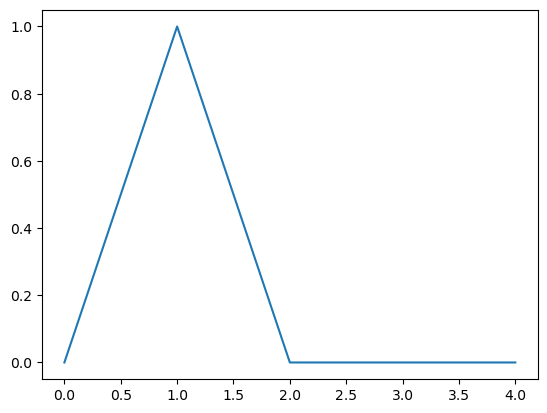

In [7]:
plt.plot(rewards)